# FINM 250 Homework 3
### TA Solutions

## Part 2

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../cmds")
from utils import (
    plot_correlation_matrix,
    calc_iterative_regression,
    calc_tangency_portfolio,
    plot_capm_regression,
    plot_mv_frontier,
)


# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# On the theme of good plot design...
plt.style.use("ggplot")

# Pandas settings.
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

# Set max columns to 100
pd.set_option("display.max_columns", 100)

# Set max rows to 100
pd.set_option("display.max_rows", 100)

# Use HTML to make the display 85% width
from IPython.core.display import HTML
HTML("<style>.container { width:85% !important; }</style>")

ADJ = 12

# We could use the code from last week to calculate the risk metrics, but given
# that we only have to calculate 4 metrics, we can use df.agg to calculate our
# desired metrics in one (well, two) line of code. We'll cover lambda functions
# in more detail during the next TA review.

UNIV_FUNCS = [
    lambda x: x.mean() * ADJ,
    lambda x: x.std() * np.sqrt(ADJ),
    lambda x: (x.mean() / x.std()) * np.sqrt(ADJ),
    lambda x: x.quantile(0.05),
]

UNIV_NAMES = [
    "Annualized Return",
    "Annualized Volatility",
    "Annualized Sharpe Ratio",
    "VaR (0.05)",
]

from functools import partial

get_data = partial(
    pd.read_excel, "../data/factor_pricing_data.xlsx", index_col=0, parse_dates=[0]
)

factors = get_data(sheet_name="factors (excess returns)")
assets = get_data(sheet_name="portfolios (excess returns)")
risk_free = get_data(sheet_name="risk-free rate")


### 1

In [2]:
factors_summary = factors.agg(UNIV_FUNCS)
factors_summary.index = UNIV_NAMES
display(factors_summary)

MKT     SMB     HML     RMW     CMA     UMD
Annualized Return        0.0849  0.0054  0.0265  0.0451  0.0277  0.0618
Annualized Volatility    0.1564  0.1014  0.1089  0.0831  0.0725  0.1535
Annualized Sharpe Ratio  0.5432  0.0535  0.2434  0.5435  0.3819  0.4023
VaR (0.05)              -0.0725 -0.0432 -0.0422 -0.0285 -0.0279 -0.0680

Yes, every factor has positive excess returns.

### 2

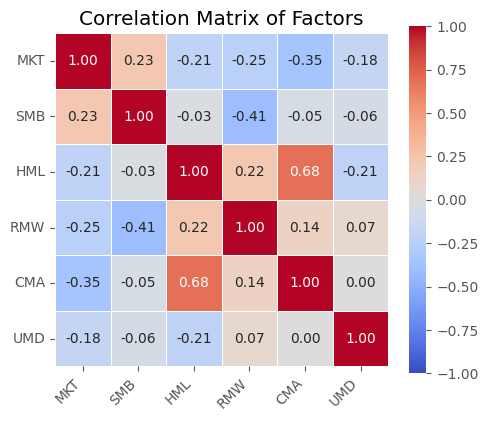

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = plot_correlation_matrix(factors.corr())

ax.set_title("Correlation Matrix of Factors")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right")
fig.tight_layout()

Yes, I would say it does. All the factors have small-ish correlations to each other, with the exception of CMA and HML. The method does succeed in making them uncorrelated. There is a discussion about this in TA review 3 [here](https://github.com/MarkHendricks/finm-quant-2025/blob/main/ta_reviews/TA_Review_3.ipynb).

### 3

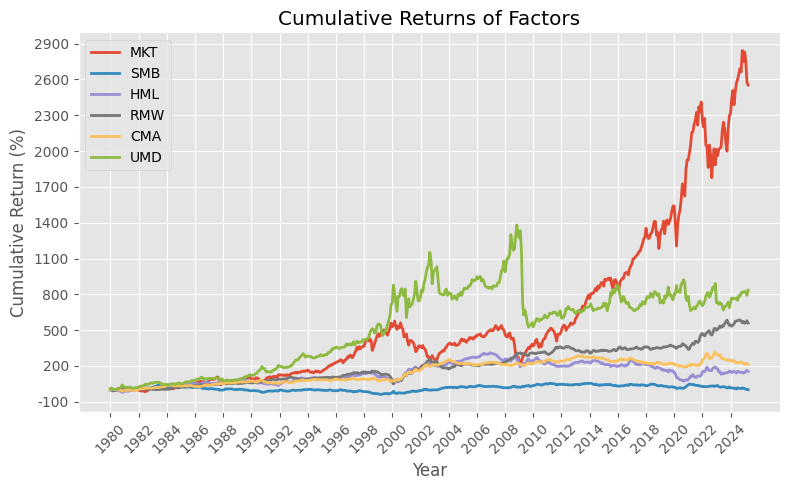

In [4]:
factors_cum = (1 + factors).cumprod() - 1

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(factors_cum.index, factors_cum, lw=2)

# Add a legend.
ax.legend(factors_cum.columns, loc="upper left")

# Make xticks every year and format them as years.
ax.set_xticks(factors_cum.index[::24])
ax.set_xticklabels(factors_cum.index[::24].year, rotation=45)
ax.set_yticks(np.arange(-1, 30, 3))
ax.set_yticklabels(["{:d}".format(x * 100) for x in ax.get_yticks()])
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative Return (%)")
ax.set_title("Cumulative Returns of Factors")
fig.tight_layout()

The market factor is the best -- though it is interesting that momentum is actually the best until about 2012.

### 4

Note that the test assets have been expanded to 49 portfolios.

Agric   Food    Soda    Beer    Smoke   Toys   \
Annualized Return        0.0905  0.0914  0.1072  0.1065  0.1399  0.0584   
Annualized Volatility    0.2162  0.1499  0.2190  0.1702  0.2235  0.2468   
Annualized Sharpe Ratio  0.4185  0.6101  0.4894  0.6254  0.6261  0.2367   
VaR (0.05)              -0.0886 -0.0600 -0.0929 -0.0665 -0.0917 -0.1068   

                          Fun     Books   Hshld   Clths   Hlth    MedEq  \
Annualized Return        0.1234  0.0687  0.0772  0.0870  0.0781  0.0979   
Annualized Volatility    0.2656  0.2069  0.1532  0.2266  0.2329  0.1795   
Annualized Sharpe Ratio  0.4645  0.3319  0.5035  0.3841  0.3355  0.5456   
VaR (0.05)              -0.1093 -0.0864 -0.0680 -0.1017 -0.1007 -0.0792   

                          Drugs   Chems   Rubbr   Txtls   BldMt   Cnstr  \
Annualized Return        0.0995  0.0781  0.0909  0.0754  0.0999  0.0942   
Annualized Volatility    0.1621  0.2017  0.2067  0.2804  0.2247  0.2568   
Annualized Sharpe Ratio  0.6135  0.3873  0.4396  0.2690  0.4445  0.3667   
VaR (0.05)              -0.0713 -0.0817 -0.0897 -0.1162 -0.0850 -0.1046   

                          Steel   FabPr   Mach    ElcEq   Autos   Aero   \
Annualized Return        0.0636  0.0536  0.0884  0.1000  0.1056  0.1049   
Annualized Volatility    0.2924  0.2972  0.2284  0.2303  0.3014  0.2264   
Annualized Sharpe Ratio  0.2176  0.1803  0.3871  0.4341  0.3506  0.4635   
VaR (0.05)              -0.1226 -0.1341 -0.0983 -0.1014 -0.1138 -0.0950   

                          Ships   Guns    Gold    Mines   Coal    Oil    \
Annualized Return        0.0920  0.1114  0.0581  0.0829  0.0679  0.0822   
Annualized Volatility    0.2576  0.2179  0.3831  0.2780  0.3949  0.2254   
Annualized Sharpe Ratio  0.3570  0.5112  0.1516  0.2983  0.1719  0.3648   
VaR (0.05)              -0.1021 -0.0955 -0.1710 -0.1139 -0.1674 -0.0988   

                          Util    Telcm   PerSv   BusSv   Hardw   Softw  \
Annualized Return        0.0762  0.0727  0.0699  0.0851  0.0872  0.1359   
Annualized Volatility    0.1384  0.1738  0.2122  0.1878  0.2557  0.2694   
Annualized Sharpe Ratio  0.5506  0.4185  0.3292  0.4531  0.3409  0.5045   
VaR (0.05)              -0.0630 -0.0860 -0.0939 -0.0796 -0.1067 -0.1078   

                          Chips   LabEq   Paper   Boxes   Trans   Whlsl  \
Annualized Return        0.1212  0.0914  0.0659  0.0889  0.0860  0.0857   
Annualized Volatility    0.2630  0.2315  0.1884  0.1992  0.2007  0.1806   
Annualized Sharpe Ratio  0.4608  0.3946  0.3499  0.4463  0.4288  0.4745   
VaR (0.05)              -0.1057 -0.0981 -0.0814 -0.0895 -0.0886 -0.0783   

                          Rtail   Meals   Banks   Insur   RlEst   Fin    \
Annualized Return        0.1135  0.0999  0.0920  0.0948  0.0522  0.1134   
Annualized Volatility    0.1868  0.1809  0.2143  0.1814  0.2504  0.2229   
Annualized Sharpe Ratio  0.6073  0.5523  0.4293  0.5225  0.2084  0.5087   
VaR (0.05)              -0.0810 -0.0746 -0.0942 -0.0786 -0.0992 -0.1038   

                          Other  
Annualized Return        0.0570  
Annualized Volatility    0.2097  
Annualized Sharpe Ratio  0.2719  
VaR (0.05)              -0.0953

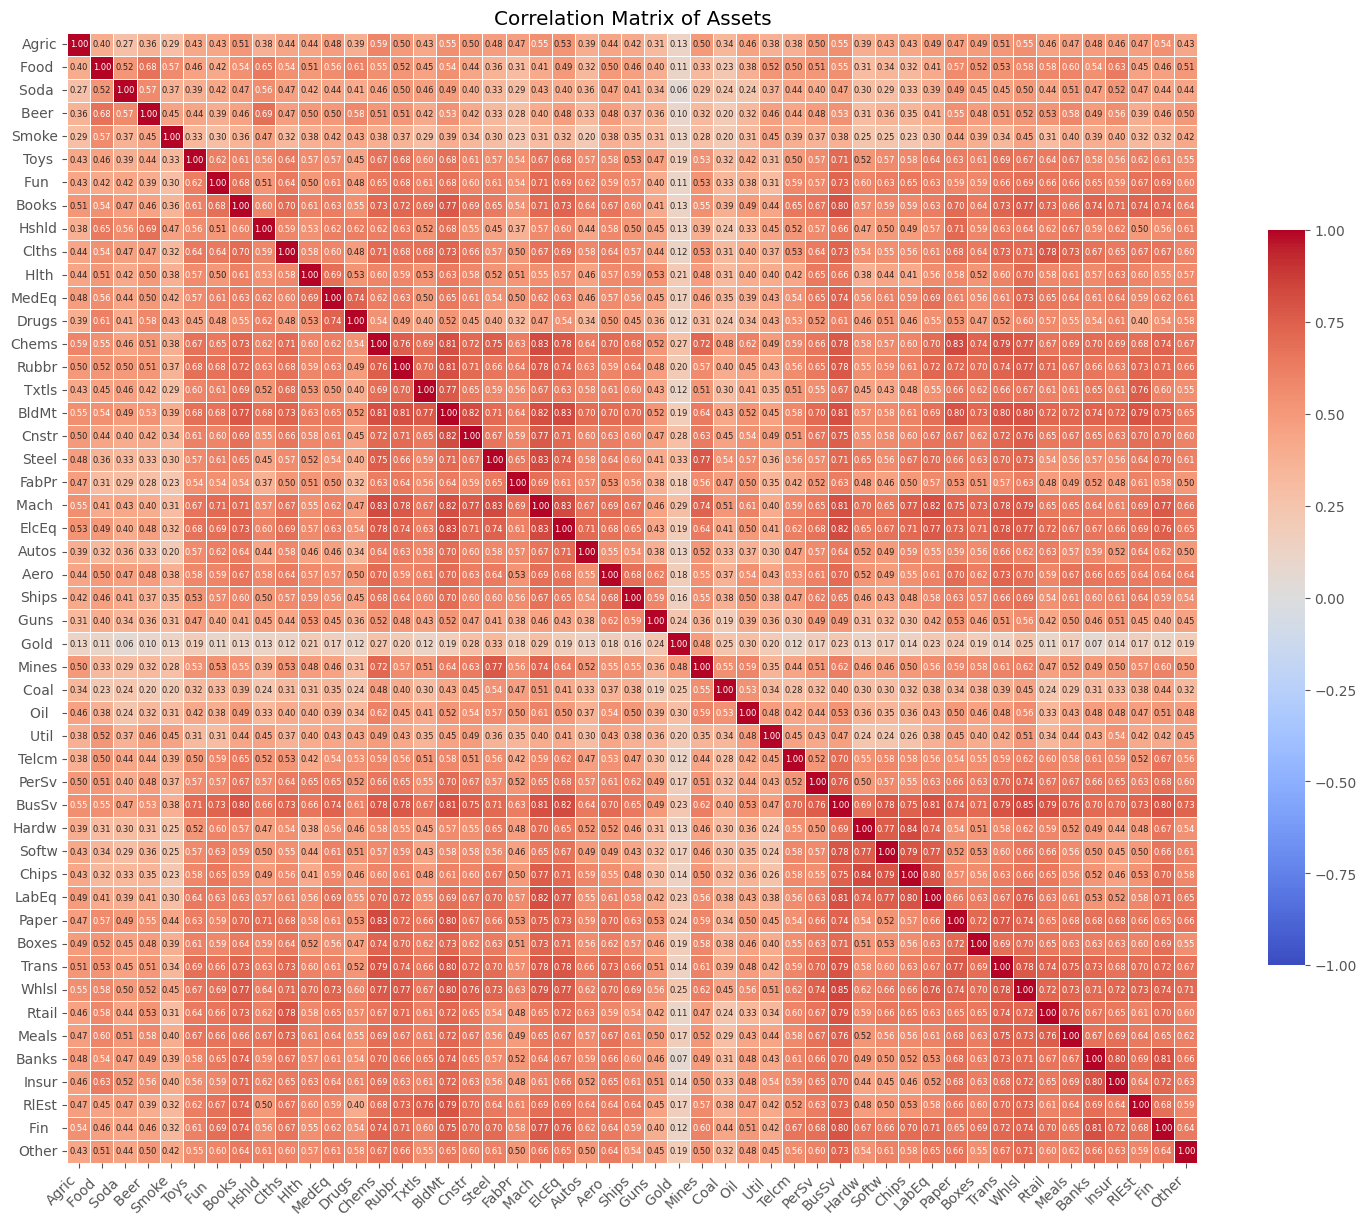

In [5]:
assets_summary = assets.aggregate(UNIV_FUNCS)
assets_summary.index = UNIV_NAMES

display(assets_summary)
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(
            assets.corr(),
            annot=True,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            linewidths=0.7,
            annot_kws={"size": 6},
            fmt=".2f",
            square=True,
            cbar_kws={"shrink": 0.5},
            ax=ax,
        )

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Correlation Matrix of Assets")
fig.tight_layout()

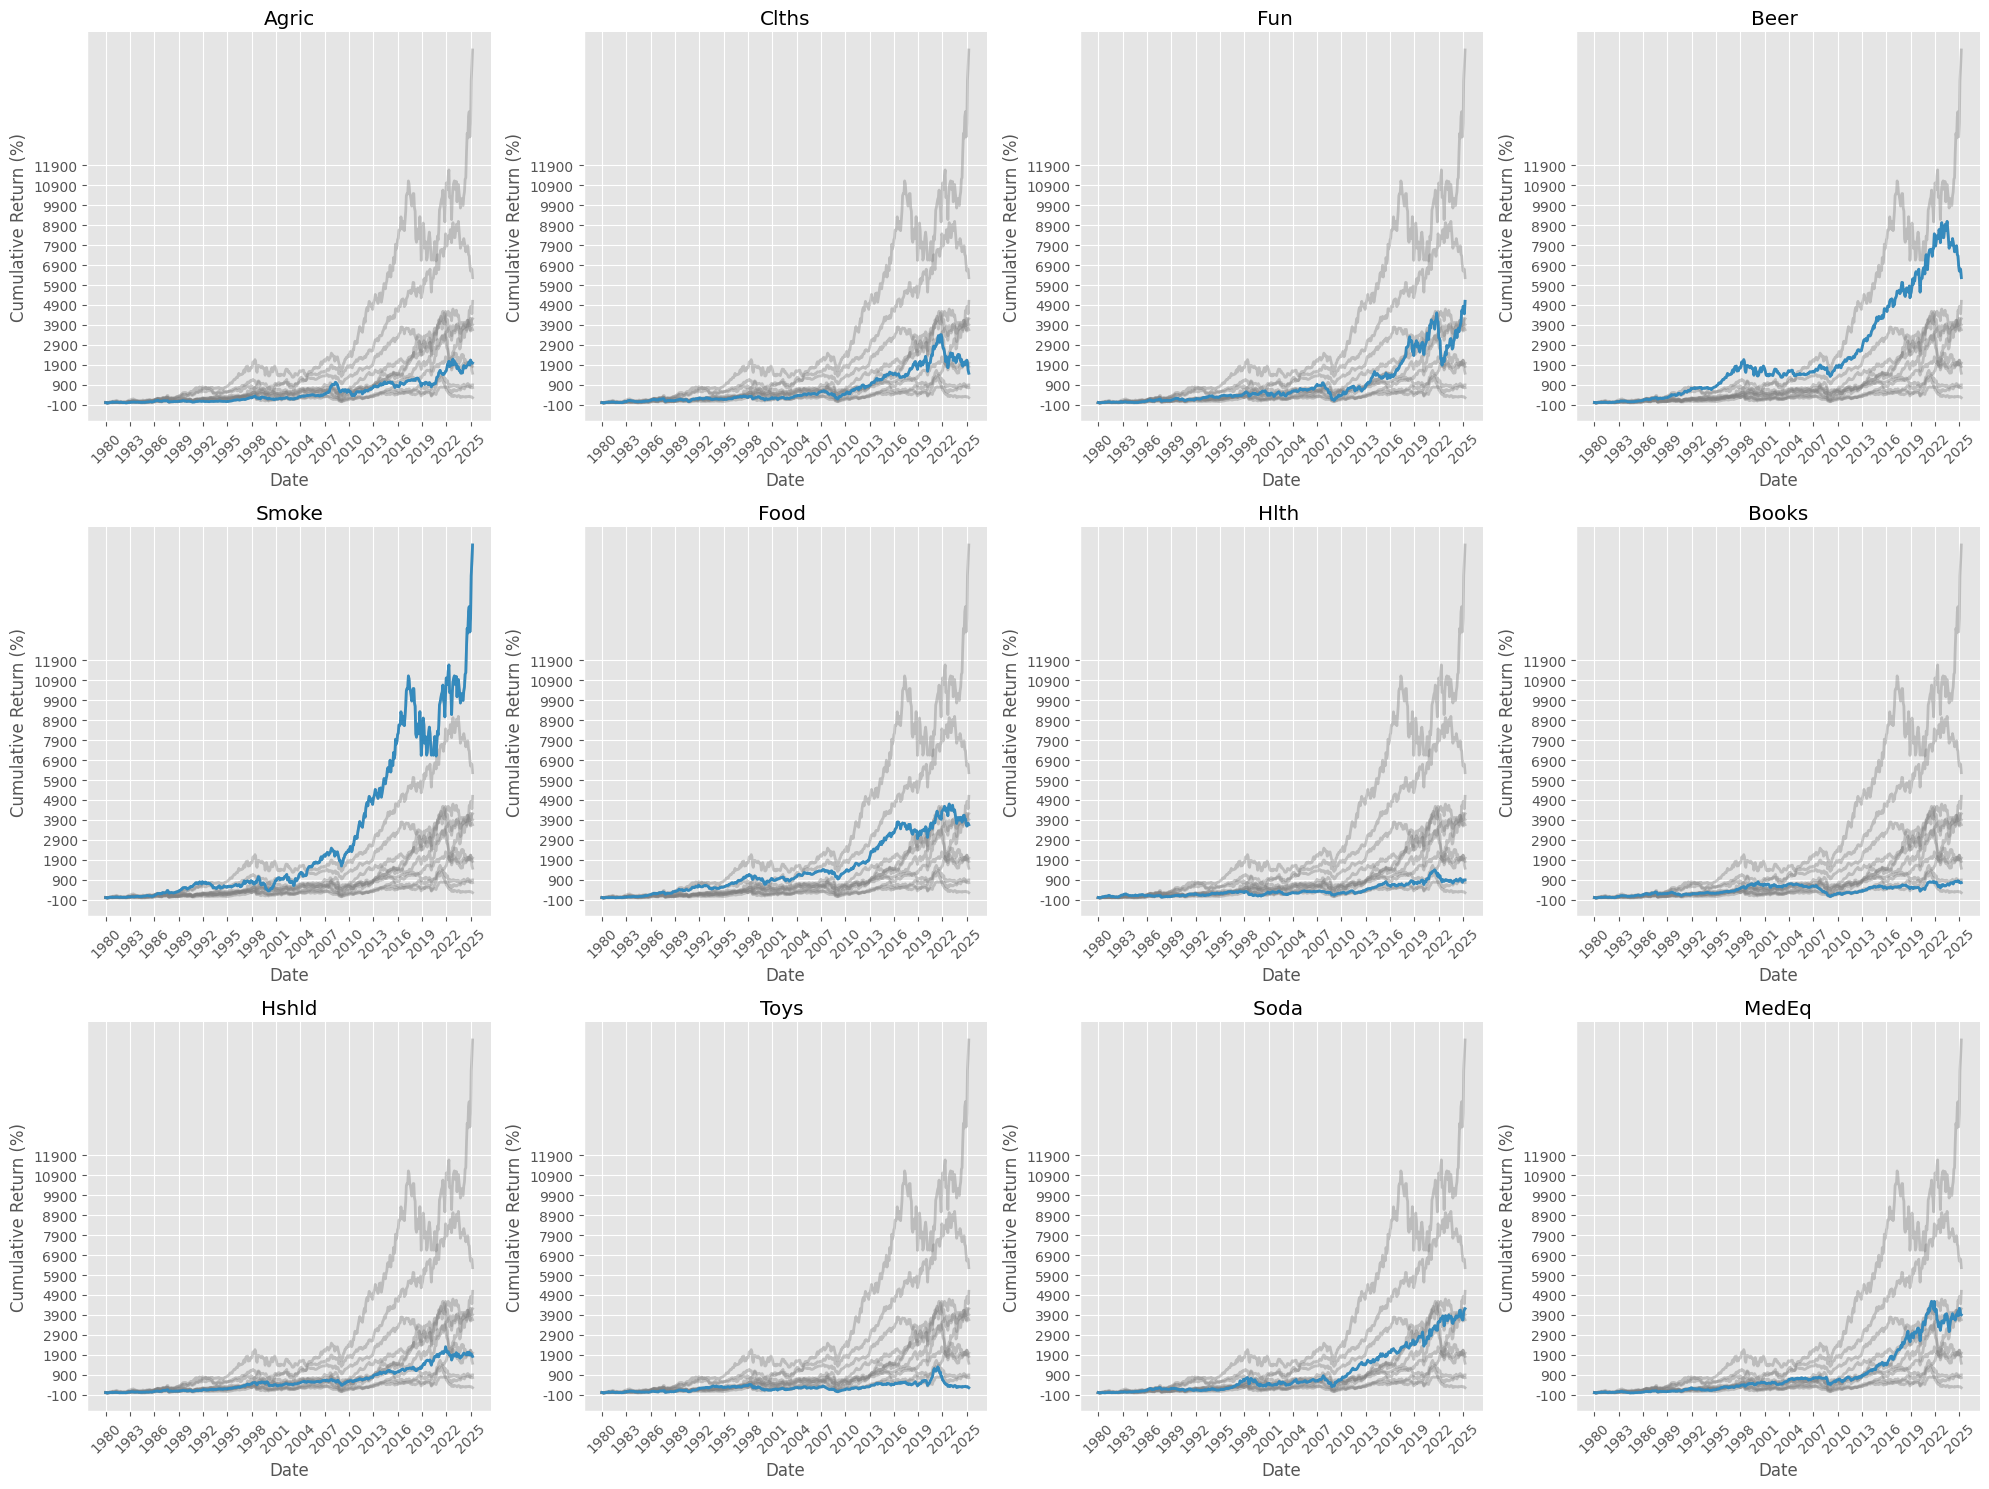

In [6]:
assets_cum = (1 + assets).cumprod() - 1

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# Plot the cumulative returns of each asset with all other assets grayed out.
# NOTE: since we are expanding to 49 assets, we will only plot the first 12.
for i, (name, asset) in enumerate(assets_cum.iloc[:, :12].items()):
    row = i % 3
    col = i % 4
    ax[row, col].plot(assets_cum.index, assets_cum.iloc[:, :12], lw=2, color="gray", alpha=0.4)
    ax[row, col].plot(asset.index, asset, lw=2, c="#348ABD", zorder=2)
    ax[row, col].set_xticks(asset.index[::36])
    ax[row, col].set_xticklabels(asset.index[::36].year, rotation=45)
    ax[row, col].set_yticks(np.arange(-1, 121, 10))
    ax[row, col].set_yticklabels(
        ["{:d}".format(x * 100) for x in ax[row, col].get_yticks()]
    )
    ax[row, col].set_xlabel("Date")
    ax[row, col].set_ylabel("Cumulative Return (%)")
    ax[row, col].set_title(name)

fig.tight_layout()

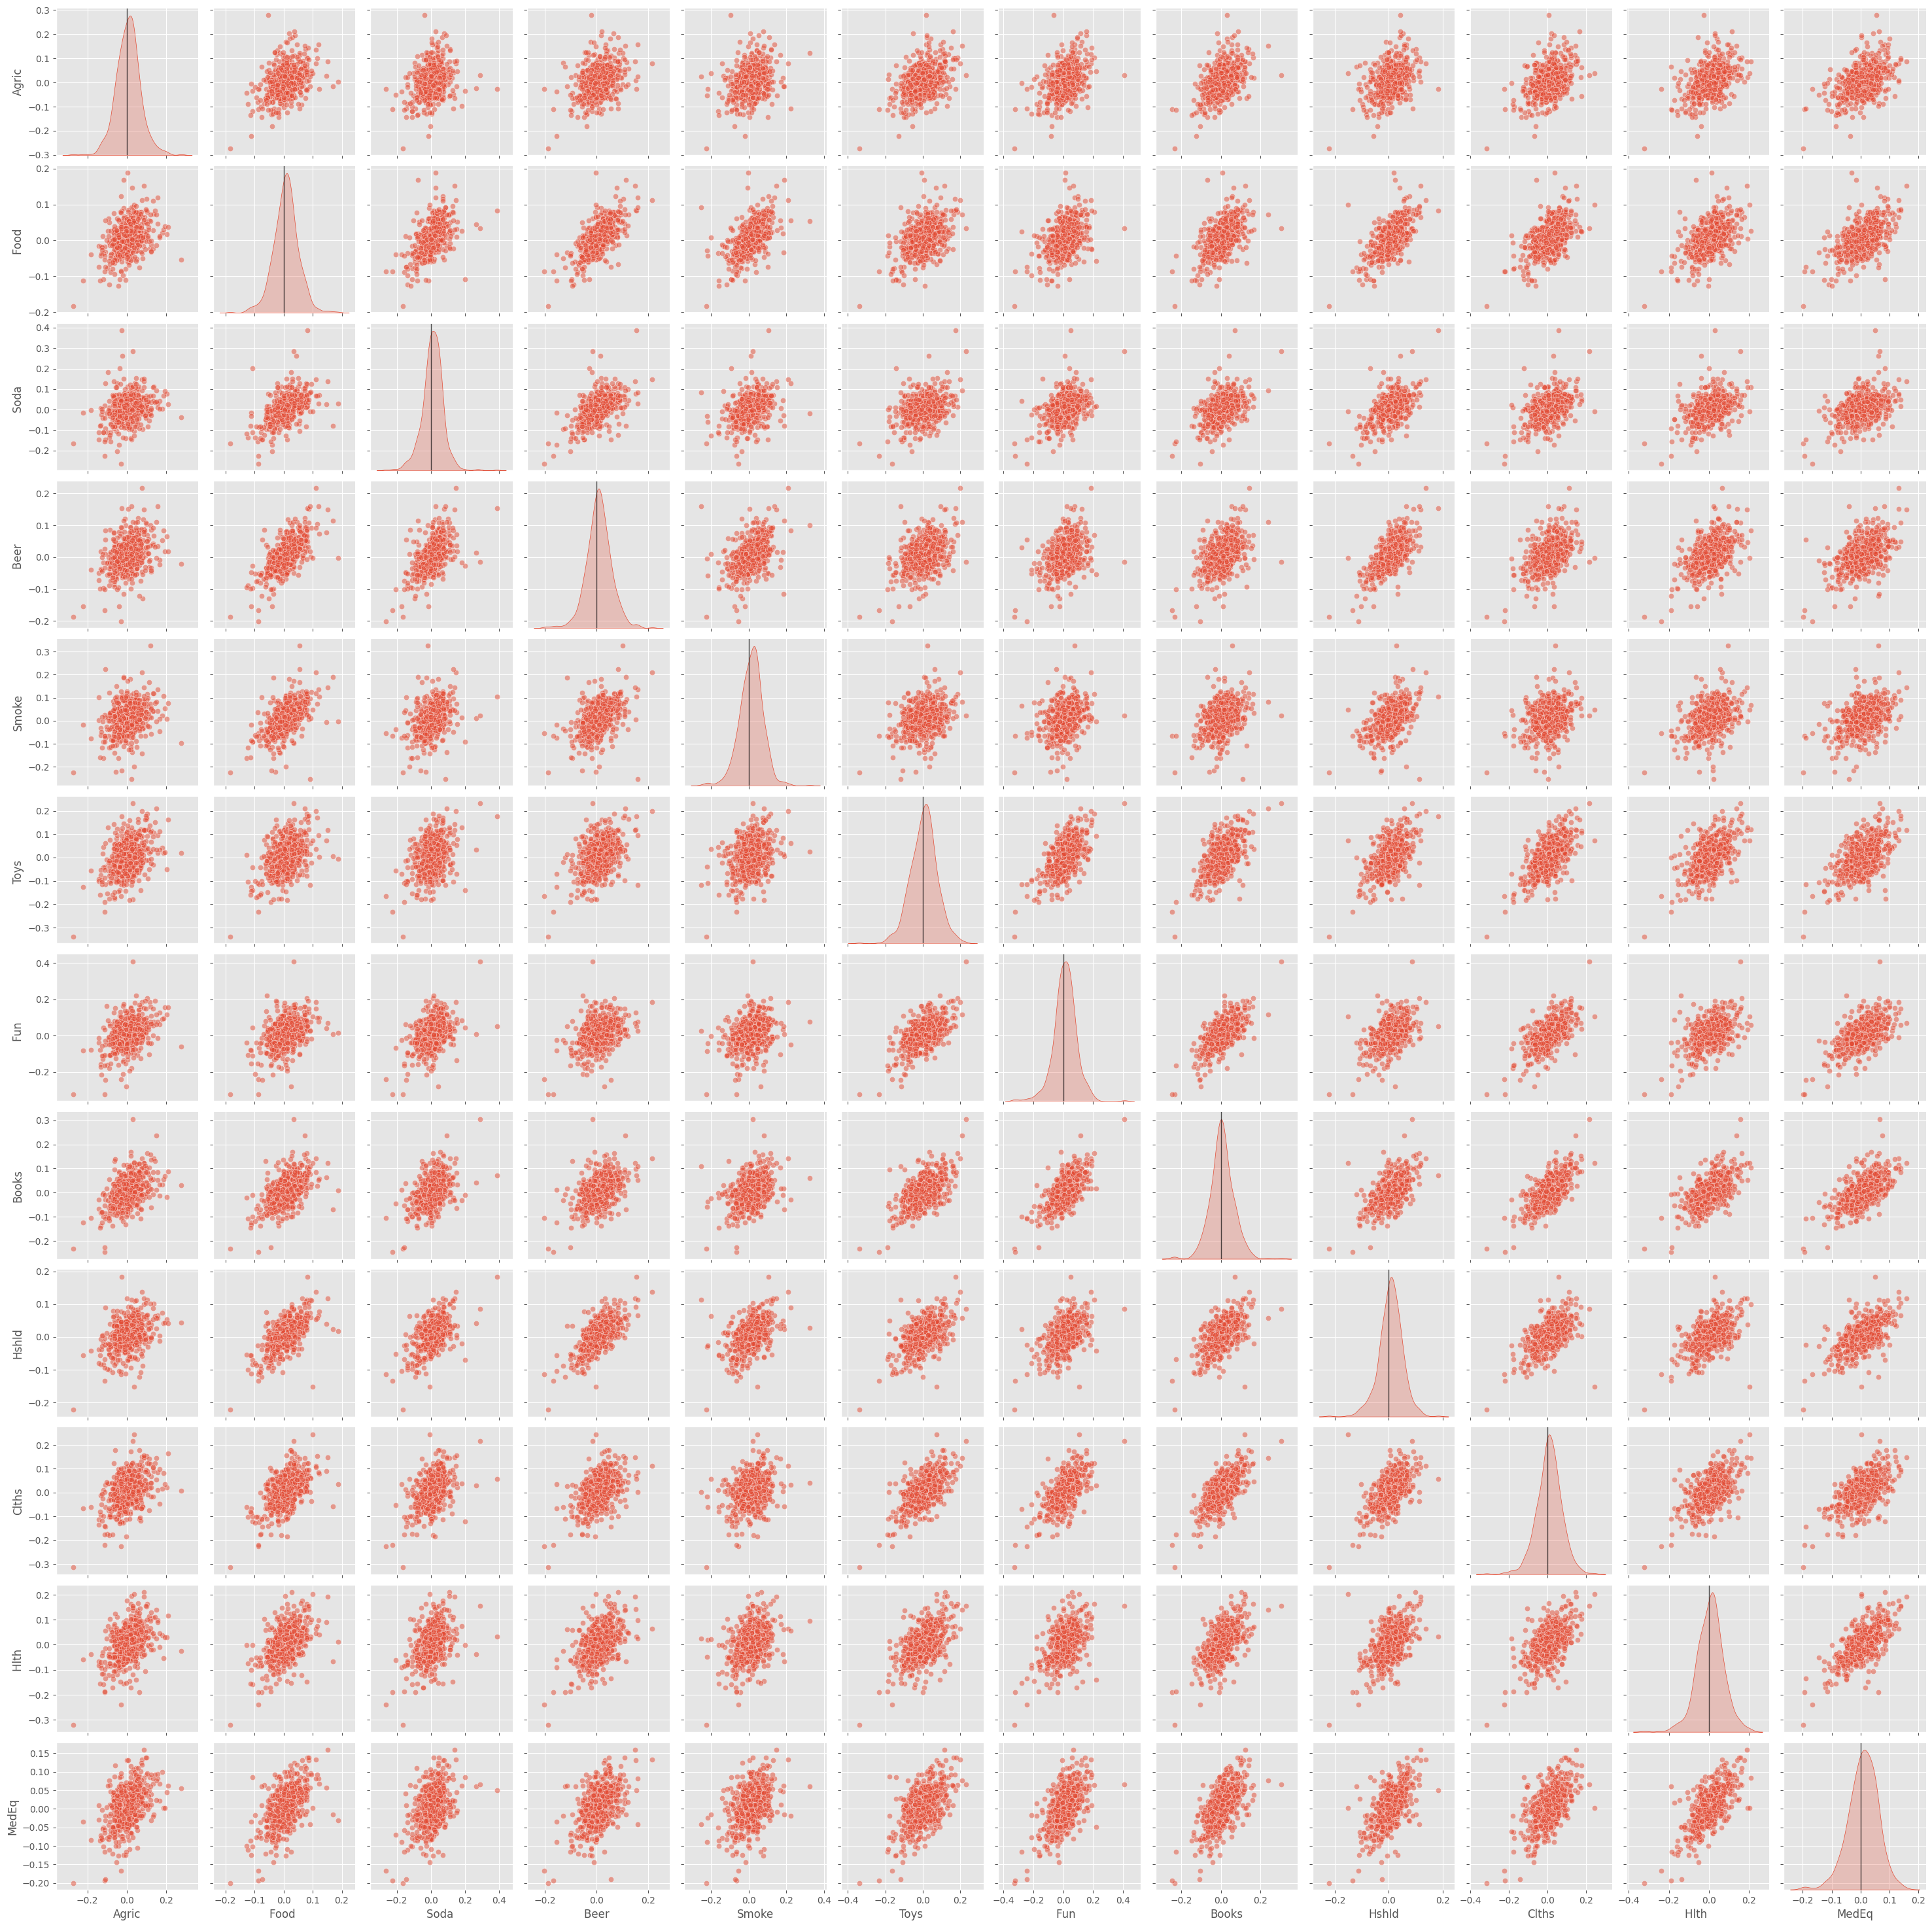

In [7]:
# Another useful function from seaborn is pairplot, which plots the pairwise
# relationships between all variables in a DataFrame.
# Again, we will only plot the first 12 assets.
ax = sns.pairplot(assets.iloc[:, :12], diag_kind="kde", plot_kws={"alpha": 0.5})

# Add a vertical line at 0 for all plots along the diagonal.
for i in range(len(ax.diag_axes)):
    ax.diag_axes[i].axvline(0, c="k", lw=1, alpha=0.7)

# Note that this is a great time to observe negative skewness and excess kurtosis in the data,
# look at the diagonal plots for each asset.

### 5

First, what would we expect if *any* difference in mean return was due to differences in volatility. The way I interpret this is that we would expect all the assets to have very similar Sharpe ratios, that is, any increase in mean return is offset by a proportional increase in volatility. 

Second, if we look at VaR, we would expect that assets with lower mean returns to have a higher VaR, and assets with higher mean returns to have a lower VaR. That is, we get "unlucky" and that brings our mean return down. We can do a quick test via plotting some scatter plots.

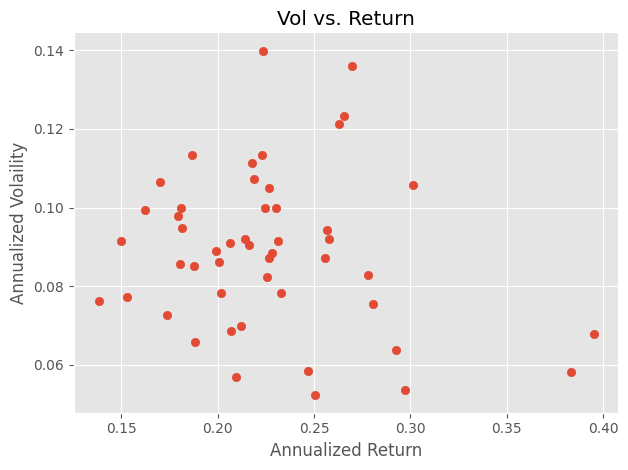

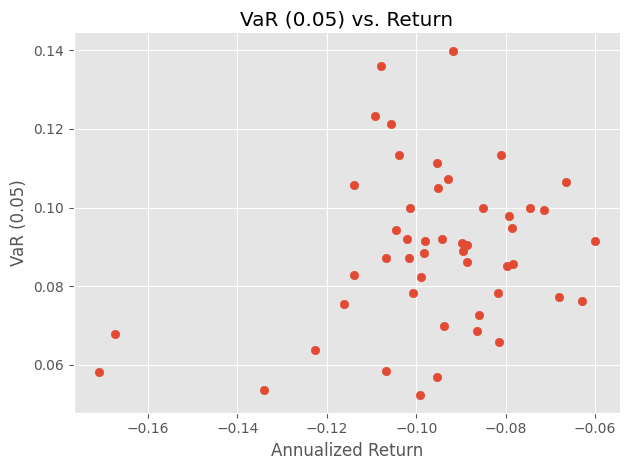

In [8]:
fig, ax = plt.subplots()

assets_transposed = assets_summary.T

ax.scatter(assets_transposed["Annualized Volatility"], assets_transposed["Annualized Return"])

ax.set_xlabel("Annualized Return")
ax.set_ylabel("Annualized Volaility")
ax.set_title("Vol vs. Return")
fig.tight_layout()

fig, ax = plt.subplots()
ax.scatter(assets_transposed["VaR (0.05)"], assets_transposed["Annualized Return"])

ax.set_xlabel("Annualized Return")
ax.set_ylabel("VaR (0.05)")
ax.set_title("VaR (0.05) vs. Return")
fig.tight_layout()

So no clear relationship. Additionally, if we look at the correlation matrix, all of the assets are highly correlated (it's bright red!). Thus, we can conclude that there is some other factor(s) at play here.

## Part 3

1, 2

In [9]:
mkt = factors[["MKT"]]
capm_regr = calc_iterative_regression(
    assets, mkt, intercept=True, one_to_many=True, adj=12
)
display(capm_regr)

Alpha   Beta  Downside Beta  R-Squared  Treynor Ratio  \
Agric  0.0229 0.7960         0.8220     0.3314         0.1137   
Food   0.0426 0.5754         0.5900     0.3604         0.1589   
Soda   0.0480 0.6968         0.7378     0.2476         0.1538   
Beer   0.0534 0.6252         0.6920     0.3299         0.1703   
Smoke  0.0880 0.6115         0.6798     0.1831         0.2288   
Toys  -0.0360 1.1109         1.2026     0.4955         0.0526   
Fun    0.0127 1.3025         1.4443     0.5882         0.0947   
Books -0.0224 1.0723         1.0296     0.6568         0.0640   
Hshld  0.0188 0.6871         0.6923     0.4918         0.1123   
Clths -0.0051 1.0846         1.0591     0.5601         0.0803   
Hlth  -0.0029 0.9535         0.9908     0.4098         0.0820   
MedEq  0.0231 0.8816         0.7925     0.5897         0.1111   
Drugs  0.0387 0.7155         0.5968     0.4762         0.1390   
Chems -0.0127 1.0699         1.0323     0.6877         0.0730   
Rubbr  0.0013 1.0544         1.0919     0.6363         0.0862   
Txtls -0.0251 1.1834         1.3254     0.4356         0.0637   
BldMt -0.0020 1.1995         1.2016     0.6966         0.0833   
Cnstr -0.0148 1.2828         1.1826     0.6102         0.0734   
Steel -0.0579 1.4309         1.4618     0.5854         0.0445   
FabPr -0.0487 1.2039         1.2940     0.4013         0.0445   
Mach  -0.0183 1.2564         1.2470     0.7398         0.0704   
ElcEq -0.0075 1.2653         1.2246     0.7379         0.0790   
Autos -0.0084 1.3429         1.3162     0.4856         0.0787   
Aero   0.0144 1.0657         1.2028     0.5416         0.0985   
Ships -0.0017 1.1031         1.0790     0.4483         0.0834   
Guns   0.0524 0.6938         0.8114     0.2480         0.1605   
Gold   0.0124 0.5378         0.5327     0.0482         0.1080   
Mines -0.0157 1.1611         1.2303     0.4267         0.0714   
Coal  -0.0265 1.1109         0.9796     0.1935         0.0611   
Oil    0.0089 0.8630         0.9308     0.3584         0.0953   
Util   0.0370 0.4621         0.5007     0.2726         0.1649   
Telcm  0.0016 0.8371         0.8859     0.5674         0.0869   
PerSv -0.0166 1.0175         0.9021     0.5622         0.0687   
BusSv -0.0088 1.1048         1.0818     0.8463         0.0770   
Hardw -0.0198 1.2596         1.1684     0.5932         0.0692   
Softw  0.0201 1.3634         1.1271     0.6262         0.0997   
Chips  0.0042 1.3767         1.3087     0.6703         0.0880   
LabEq -0.0125 1.2222         1.1172     0.6816         0.0747   
Paper -0.0136 0.9365         0.8979     0.6044         0.0704   
Boxes  0.0082 0.9502         1.0404     0.5565         0.0936   
Trans -0.0030 1.0483         1.0191     0.6673         0.0821   
Whlsl  0.0012 0.9943         1.0235     0.7416         0.0862   
Rtail  0.0307 0.9737         0.8732     0.6642         0.1165   
Meals  0.0249 0.8839         0.9131     0.5835         0.1131   
Banks  0.0010 1.0719         1.0903     0.6115         0.0858   
Insur  0.0206 0.8728         0.8482     0.5663         0.1086   
RlEst -0.0467 1.1638         1.2866     0.5281         0.0448   
Fin    0.0071 1.2514         1.2864     0.7709         0.0906   
Other -0.0299 1.0228         1.0060     0.5816         0.0557   

       Information Ratio  Tracking Error  
Agric             0.1294          0.0147  
Food              0.3551          0.0100  
Soda              0.2526          0.0158  
Beer              0.3829          0.0116  
Smoke             0.4355          0.0168  
Toys             -0.2051          0.0146  
Fun               0.0747          0.0142  
Books            -0.1849          0.0101  
Hshld             0.1719          0.0091  
Clths            -0.0339          0.0125  
Hlth             -0.0159          0.0149  
MedEq             0.2005          0.0096  
Drugs             0.3298          0.0098  
Chems            -0.1130          0.0094  
Rubbr             0.0104          0.0104  
Txtls            -0.1191          0.0176  
BldMt            -0.0161  

### 3 

Alphas would be 0 (or at least statistically insignificant) for all portfolios. Treynor ratios would be equal across all assets, and equal to the market return. Information ratios should also be 0, since the alphas are 0.

### 4

In [10]:
# Calculate MAE for alpha.
mae_alpha = capm_regr["Alpha"].abs().mean()
print(f"MAE for CAPM: {mae_alpha:.4f}")

MAE for CAPM: 0.0214


The estimates should be very small, yet they average 2.14% annualized, which is not small at all. Looking at the MAE stat, we can confirm that the CAPM makes for a poor pricing model (at least when using the market as the only factor).

### 4

In [11]:
multi_factor_regression = calc_iterative_regression(
    assets, factors, intercept=True, one_to_many=True, adj=12
)
display(multi_factor_regression)

Alpha  R-Squared  MKT Beta  SMB Beta  HML Beta  RMW Beta  CMA Beta  \
Agric  0.0027     0.3622    0.8115    0.3456    0.1058    0.1476    0.1217   
Food  -0.0057     0.4881    0.7286   -0.0774   -0.0234    0.4890    0.4737   
Soda   0.0083     0.3142    0.8214   -0.0133    0.0136    0.5228    0.4316   
Beer   0.0004     0.4466    0.7858   -0.0934   -0.1854    0.5904    0.5189   
Smoke  0.0271     0.2967    0.8165   -0.1155   -0.0577    0.6347    0.7552   
Toys  -0.0506     0.5615    1.0753    0.6044   -0.1857    0.5139    0.2747   
Fun    0.0433     0.6190    1.1848    0.2458    0.0363   -0.0221   -0.2533   
Books -0.0412     0.7070    1.0923    0.2963    0.2090    0.3169    0.0488   
Hshld -0.0215     0.5882    0.8108   -0.0520   -0.2266    0.4964    0.5176   
Clths -0.0309     0.6450    1.0952    0.4080   -0.0310    0.7636    0.0629   
Hlth  -0.0527     0.4941    1.0075    0.5646    0.0366    0.7416    0.1398   
MedEq  0.0118     0.6102    0.8894    0.1538   -0.2500    0.1733    0.2255   
Drugs  0.0203     0.5381    0.8006   -0.2300   -0.3366    0.1350    0.4536   
Chems -0.0414     0.7550    1.1438    0.1495    0.1907    0.3791    0.2387   
Rubbr -0.0182     0.7101    1.0379    0.5624   -0.0424    0.4205    0.2034   
Txtls -0.0545     0.6503    1.1535    0.9829    0.4728    0.7529    0.0516   
BldMt -0.0374     0.7849    1.2462    0.4343    0.2653    0.5628    0.0908   
Cnstr -0.0478     0.6731    1.2981    0.5776    0.2431    0.4726    0.0087   
Steel -0.0455     0.6534    1.3621    0.5049    0.2188   -0.2046    0.2142   
FabPr -0.0382     0.5309    1.0348    1.0243    0.3658    0.2983   -0.4657   
Mach  -0.0139     0.7826    1.2010    0.4178    0.0166    0.0689    0.1241   
ElcEq -0.0118     0.7466    1.2493    0.2012    0.0245    0.1690   -0.0194   
Autos  0.0093     0.5414    1.2671    0.3258    0.1016    0.1841    0.0184   
Aero  -0.0147     0.6049    1.1349    0.1704    0.2103    0.4602    0.1718   
Ships -0.0524     0.5392    1.1896    0.4986    0.2195    0.6791    0.3171   
Guns  -0.0026     0.3349    0.8103    0.2370    0.1671    0.7375    0.1445   
Gold  -0.0181     0.0679    0.6031    0.3424   -0.3500    0.1842    0.8675   
Mines -0.0354     0.4802    1.1884    0.4038    0.1400    0.2542    0.3937   
Coal  -0.0616     0.2359    1.1530    0.6233    0.3026    0.0661    0.3944   
Oil   -0.0389     0.4628    1.0084    0.1042    0.4773    0.2495    0.3310   
Util   0.0005     0.3895    0.6025   -0.1877    0.2136    0.1448    0.2945   
Telcm  0.0067     0.5992    0.8710   -0.2275    0.0484   -0.1706    0.1992   
PerSv -0.0524     0.6256    1.0461    0.4594    0.1594    0.5031   -0.0524   
BusSv -0.0099     0.8755    1.0556    0.3363   -0.1008    0.1679   -0.0408   
Hardw  0.0422     0.6662    1.0771    0.0506   -0.4159   -0.4240   -0.1385   
Softw  0.0773     0.7547    1.1429    0.1566   -0.6539   -0.1232   -0.4784   
Chips  0.0601     0.7506    1.1987    0.1303   -0.5570   -0.3950   -0.0124   
LabEq  0.0085     0.7554    1.1141    0.3847   -0.5110   -0.1465    0.2810   
Paper -0.0541     0.6976    1.0466    0.1427    0.0234    0.5212    0.4853   
Boxes -0.0023     0.5863    0.9679    0.0929    0.1551    0.2816   -0.0523   
Trans -0.0262     0.7252    1.0755    0.2843    0.1859    0.4528   -0.0065   
Whlsl -0.0242     0.7997    1.0096    0.4183    0.0320    0.3725    0.1324   
Rtail  0.0209     0.6899    0.9711    0.1204   -0.1339    0.3826   -0.0476   
Meals -0.0090     0.6524    0.9503    0.2008   -0.0355    0.5914    0.2227   
Banks -0.0092     0.7873    1.1196   -0.0405    0.9594    0.0228   -0.4976   
Insur -0.0067     0.6772    0.9732   -0.1130    0.5425    0.1952   -0.1126   
RlEst -0.0641     0.7069    1.1089    0.8663    0.5187    0.4502   -0.1608   
Fin    0.0293     0.8219    1.1977    0.0166    0.5223   -0.4256   -0.4112   
Other -0.0427     0.5891    1.0566    0.0477    0.0334    0.1633    0.1206   

       UMD Beta  Information Ratio  Tracking Error  
Agric    0.0679             0.0154          0.1727  
F

### 2

In [12]:
multi_factor_mae = multi_factor_regression["Alpha"].abs().mean()
print(f"MAE Multi-Factor: {multi_factor_mae:.4f}")

MAE Multi-Factor: 0.0287


Again, they should be 0. They've actually gotten *worse*, which means that the multifactor model is not only does a poor job in explaining all of the returns, it does a worse job than the CAPM.